In [67]:
import numpy as np
import matplotlib.pyplot as plt


### 1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

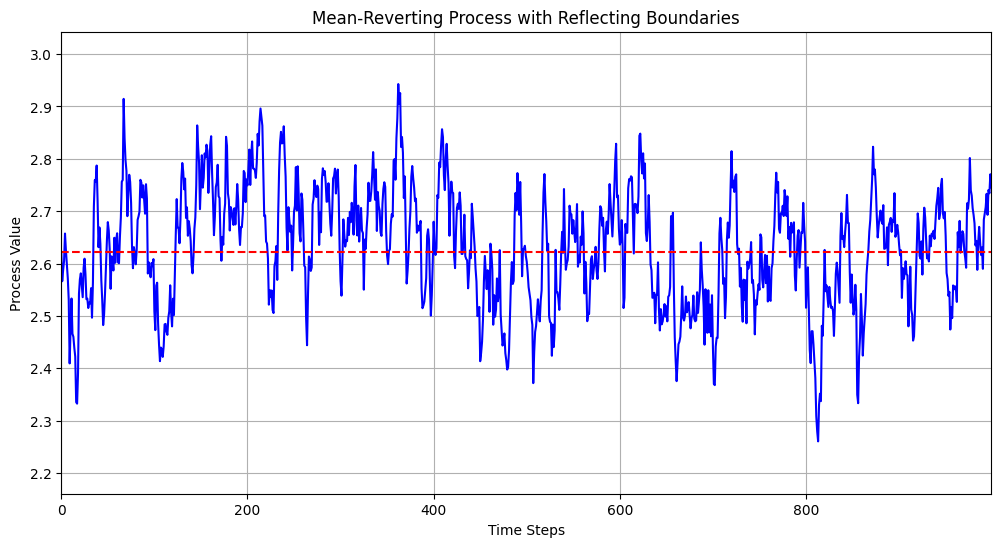

In [121]:
def mean_reverting_process(a, b, num_steps=1000, k=0.1, sigma=0.05, seed=42):
    np.random.seed(seed)

    mu = np.random.uniform(a, b)

    X = np.zeros(num_steps)
    X[0] = mu  

    for t in range(1, num_steps):
        X_new = X[t-1] + k * (mu - X[t-1]) + sigma * np.random.randn()

        if X_new < a:
            X_new = a + (a - X_new)  
        elif X_new > b:
            X_new = b - (X_new - b)  

        # ensure X_new stays within bounds [a, b]
        X[t] = np.clip(X_new, a, b)

    return X, mu

def plot_process(X, mu, num_steps=1000):
    time = np.arange(num_steps)

    plt.figure(figsize=(12, 6))
    plt.plot(time, X, label='Mean-Reverting Process', color='blue')
    plt.hlines(mu, xmin=0, xmax=num_steps-1, colors='red', linestyles='dashed', label=f'Mean Level (μ={mu:.3f})')
    plt.title('Mean-Reverting Process with Reflecting Boundaries')
    plt.xlabel('Time Steps')
    plt.ylabel('Process Value')
    plt.xlim(0, num_steps-1)
    plt.ylim(min(X)-0.1, max(X)+0.1) 
    plt.grid(True)
    plt.show()

a = 0.0
b = 7.0
num_steps = 1000
X, mu = mean_reverting_process(a, b, num_steps=num_steps)
plot_process(X, mu, num_steps=num_steps)


In [ ]:
# your code

### 2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

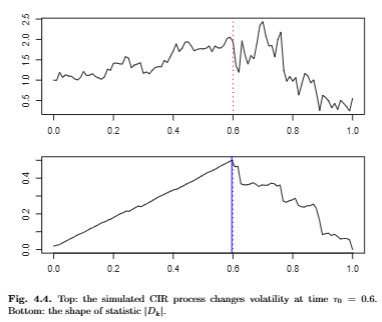

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

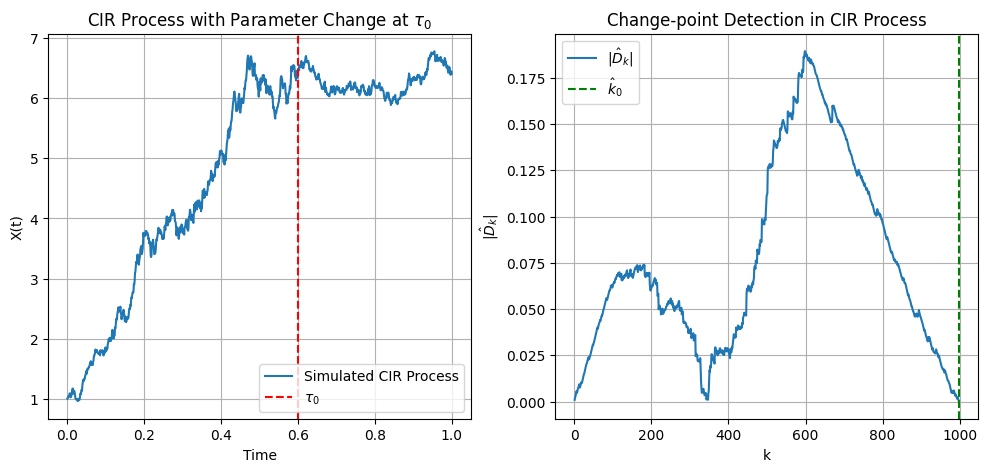

Estimated change-point k_0 is at time index: 998
Corresponding time: 0.998
True change-point τ_0 is at time: 0.6


In [68]:
class CIRProcess:
    def __init__(self, T, Nt, theta1, theta2, tau_0, kappa=2, mu=6, X0=1):
        self.T = T           
        self.Nt = Nt         
        self.dt = T / Nt     
        self.theta1 = theta1  # parameter for t < tau_0
        self.theta2 = theta2  # parameter for t >= tau_0
        self.tau_0 = tau_0    
        self.kappa = kappa    
        self.mu = mu        
        self.X0 = X0         
        self.t_data = np.linspace(0, T, Nt + 1)
        self.X_data = np.zeros(Nt + 1)
        self.X_data[0] = X0

    def simulate(self):
        """Simulate the CIR process with Euler-Maruyama method."""
        for i in range(1, self.Nt + 1):
            theta = self.theta1 if self.t_data[i] < self.tau_0 else self.theta2
            dWt = np.random.normal(0, np.sqrt(self.dt))
            self.X_data[i] = (
                self.X_data[i - 1] 
                + self.kappa * (self.mu - self.X_data[i - 1]) * self.dt 
                + theta * np.sqrt(max(self.X_data[i - 1], 0)) * dWt
            )
        return self.t_data, self.X_data

    def kernel(self, x, xi, h):
        """Gaussian kernel function."""
        return np.exp(-((x - xi) ** 2) / (2 * h ** 2))

    def calculate_residuals(self, h=0.05):
        """Calculate residuals using kernel-based drift estimation."""
        Z_data = []
        for i in range(1, self.Nt):
            # Kernel-weighted drift estimation at X_data[i]
            b_hat = sum(
                self.kernel(self.X_data[i], self.X_data[j], h) * (self.X_data[j + 1] - self.X_data[j]) / self.dt
                for j in range(self.Nt - 1)
            ) / sum(self.kernel(self.X_data[i], self.X_data[j], h) for j in range(self.Nt - 1))

            Z_i = (self.X_data[i + 1] - self.X_data[i] - b_hat * self.dt) / np.sqrt(self.dt)
            Z_data.append(Z_i)
        self.Z_data = np.array(Z_data)
        return self.Z_data

    def calculate_statistic(self):
        """Calculate the statistic |D_k| for change-point detection."""
        n = len(self.Z_data)
        S_n = np.sum(self.Z_data ** 2)
        D_k = []
        for k in range(1, n):
            S_k = np.sum(self.Z_data[:k] ** 2)
            S_n_k = S_n - S_k
            D_k_value = (k / n - S_k / S_n)  # Compute D_k
            D_k.append(D_k_value)
        self.D_k = np.array(D_k)
        self.k_0 = np.argmin(np.abs(self.D_k)) + 1  # +1 because k is 1-based in notation
        return self.k_0

    def plot_results(self):
        """Plot the simulated CIR process and |D_k| statistic."""
        # Plot the CIR process
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.t_data, self.X_data, label="Simulated CIR Process")
        plt.axvline(x=self.tau_0, color="red", linestyle="--", label=r"$\tau_0$")
        plt.xlabel("Time")
        plt.ylabel("X(t)")
        plt.legend()
        plt.title("CIR Process with Parameter Change at $\\tau_0$")
        plt.grid()

        # plot |D_k| and indicate the change-point k_0
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(1, len(self.D_k) + 1), np.abs(self.D_k), label=r"$|\hat{D}_k|$")
        plt.axvline(x=self.k_0, color="green", linestyle="--", label=r"$\hat{k}_0$")
        plt.xlabel("k")
        plt.ylabel(r"$|\hat{D}_k|$")
        plt.title("Change-point Detection in CIR Process")
        plt.legend()
        plt.grid()
        plt.show()

        print(f"Estimated change-point k_0 is at time index: {self.k_0}")
        print(f"Corresponding time: {self.t_data[self.k_0]}")
        print(f"True change-point τ_0 is at time: {self.tau_0}")


cir_process = CIRProcess(T=1, Nt=1000, theta1=1.0, theta2=0.5, tau_0=0.6)
cir_process.simulate()
cir_process.calculate_residuals()
cir_process.calculate_statistic()
cir_process.plot_results()


In [ ]:
# your code

### 3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

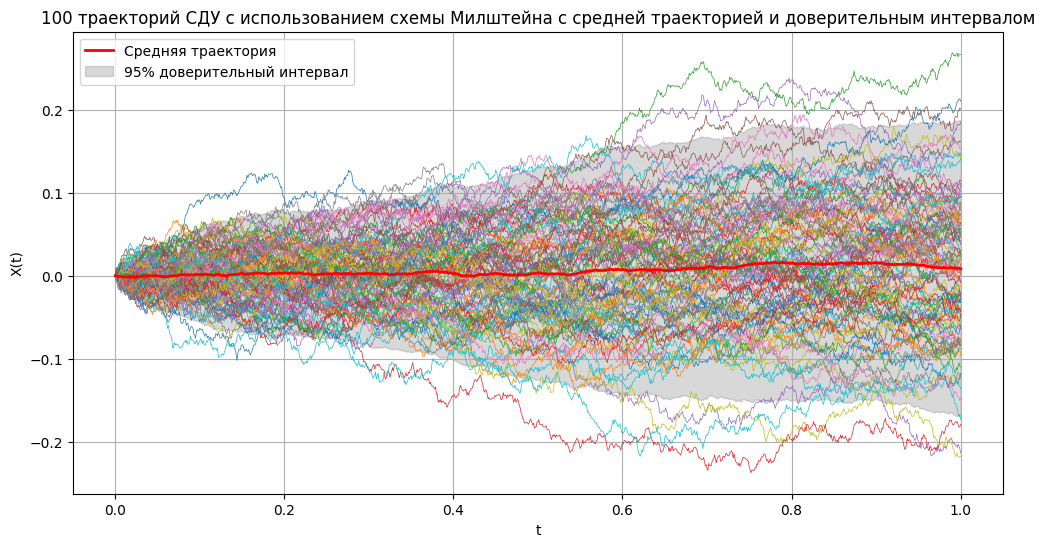

In [77]:
T = 1
dt = 0.001
N_steps = int(T / dt)
x0 = 0

def simulate_milstein_multiple(num_trajectories, T, dt, N_steps, x0):
    t_data = np.linspace(0, T, N_steps + 1)
    trajectories = np.zeros((num_trajectories, N_steps + 1))
    trajectories[:, 0] = x0

    for j in range(num_trajectories):
        for i in range(N_steps):
            t = i * dt
            dW = np.sqrt(dt) * np.random.randn()  #
            X = trajectories[j, i]
            drift = 0.03 * t * X - X**3
            diffusion = 0.1

            trajectories[j, i + 1] = X + drift * dt + diffusion * dW + 0.5 * diffusion**2 * (dW**2 - dt)

    return t_data, trajectories
num_trajectories = 100
t_data, trajectories = simulate_milstein_multiple(num_trajectories, T, dt, N_steps, x0)
average_trajectory = np.mean(trajectories, axis=0)
std_trajectory = np.std(trajectories, axis=0)

plt.figure(figsize=(12, 6))

for j in range(num_trajectories):
    plt.plot(t_data, trajectories[j], linewidth=0.5, alpha=1)  # Прозрачность для отдельных траекторий

plt.plot(t_data, average_trajectory, color='red', label="Средняя траектория", linewidth=2)

plt.fill_between(t_data, average_trajectory - 1.96 * std_trajectory, average_trajectory + 1.96 * std_trajectory, color='grey', alpha=0.3, label="95% доверительный интервал")

plt.title("100 траекторий СДУ с использованием схемы Милштейна с средней траекторией и доверительным интервалом")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.legend(loc="best")
plt.grid(True)

plt.show()


In [ ]:
# your code

### 4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


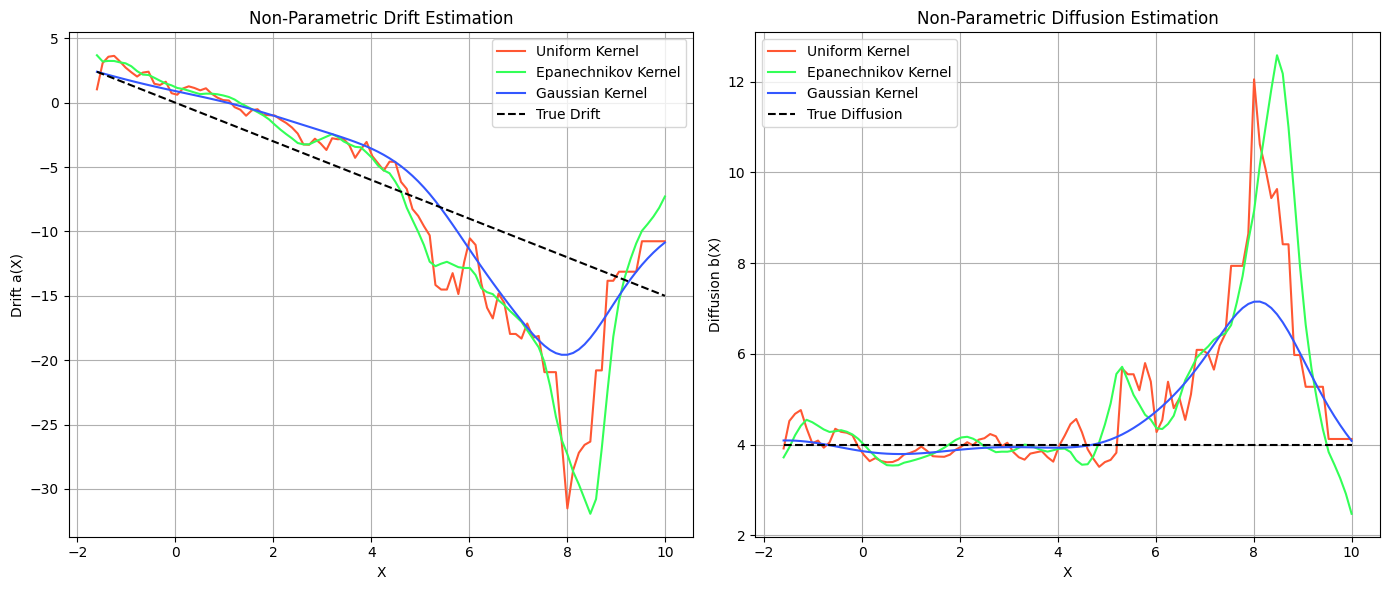

In [215]:
class OrnsteinUhlenbeckSimulation:
    def __init__(self, theta1, theta2, theta3, X0, T=10, dt=0.01, seed=42):
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = theta3
        self.X0 = X0
        self.T = T
        self.dt = dt
        self.N = int(T / dt)
        self.time = np.linspace(0, T, self.N + 1)
        np.random.seed(seed)

    def simulate(self):
        X = np.zeros(self.N + 1)
        X[0] = self.X0
        for i in range(1, self.N + 1):
            dW = np.sqrt(self.dt) * np.random.randn()
            X[i] = X[i - 1] + (self.theta1 - self.theta2 * X[i - 1]) * self.dt + self.theta3 * dW
        return X

class KernelDensityEstimator:
    def __init__(self, kernel_func, h=1.0):
        self.kernel_func = kernel_func
        self.h = h

    def kernel_estimation(self, x_grid, X_prev, delta_X, dt):
        a_est = np.zeros_like(x_grid)
        b_est = np.zeros_like(x_grid)
        for idx, x in enumerate(x_grid):
            u = (X_prev - x) / self.h
            weights = self.kernel_func(u)
            sum_weights = np.sum(weights)
            if sum_weights > 0:
                a_est[idx] = np.sum(weights * (delta_X / dt)) / sum_weights
                b_est[idx] = np.sum(weights * ((delta_X) ** 2 / dt)) / sum_weights
            else:
                a_est[idx] = np.nan
                b_est[idx] = np.nan
        return a_est, b_est

def uniform_kernel(u):
    return 0.5 * (np.abs(u) <= 1)

def epanechnikov_kernel(u):
    return (0.75 * (1 - u ** 2)) * (np.abs(u) <= 1)

def gaussian_kernel(u):
    return norm.pdf(u)

def plot_results(X, time, X_prev, delta_X, x_grid, kernels, a_true, b_true):
    colors = ['#FF5733', '#33FF57', '#3357FF']  # Новые цвета графиков

    plt.figure(figsize=(14, 6))

    # Plot drift estimation
    plt.subplot(1, 2, 1)
    for idx, (name, kernel) in enumerate(kernels.items()):
        estimator = KernelDensityEstimator(kernel)
        a_est, _ = estimator.kernel_estimation(x_grid, X_prev, delta_X, dt=0.01)

        plt.plot(x_grid, a_est, label=f'{name} Kernel', color=colors[idx])

    plt.plot(x_grid, a_true, 'k--', label='True Drift')
    plt.xlabel('X')
    plt.ylabel('Drift a(X)')
    plt.title('Non-Parametric Drift Estimation')
    plt.legend()
    plt.grid(True)

    # Plot diffusion estimation
    plt.subplot(1, 2, 2)
    for idx, (name, kernel) in enumerate(kernels.items()):
        estimator = KernelDensityEstimator(kernel)
        _, b_est = estimator.kernel_estimation(x_grid, X_prev, delta_X, dt=0.01)

        plt.plot(x_grid, b_est, label=f'{name} Kernel', color=colors[idx])

    plt.plot(x_grid, b_true, 'k--', label='True Diffusion')
    plt.xlabel('X')
    plt.ylabel('Diffusion b(X)')
    plt.title('Non-Parametric Diffusion Estimation')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


theta1 = 1
theta2 = 1.5
theta3 = 2
X0 = 10

ou_simulation = OrnsteinUhlenbeckSimulation(theta1, theta2, theta3, X0)
X = ou_simulation.simulate()

X_prev = X[:-1]
delta_X = X[1:] - X[:-1]
x_grid = np.linspace(np.min(X), np.max(X), 100)

kernels = {
    'Uniform': uniform_kernel,
    'Epanechnikov': epanechnikov_kernel,
    'Gaussian': gaussian_kernel
}

a_true = -theta2 * x_grid
b_true = theta3 ** 2 * np.ones_like(x_grid)

# Plot results
plot_results(X, ou_simulation.time, X_prev, delta_X, x_grid, kernels, a_true, b_true)


In [151]:
# your code

5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

In [200]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import plotly.graph_objects as go

class Models:
    def __init__(self, file):
        self.df = file
        self.df.columns = ['Time', 'Value']
        self.time = self.df['Time'].values
        self.values = self.df['Value'].values
        self.dt = np.diff(self.time)
        self.theta_ou, self.mu_ou, self.sigma_ou = self.estimate_ou_params()
        self.mu_gbm, self.sigma_gbm = self.estimate_gbm_params()
        self.theta_cir, self.mu_cir, self.sigma_cir = self.estimate_cir_params()

    # Функция логарифмической правдоподобия для OU
    def ou_log_likelihood(self, params, x, dt):
        theta, mu, sigma = params
        n = len(x) - 1
        likelihood = 0
        for i in range(n):
            m = x[i] * np.exp(-theta * dt[i]) + mu * (1 - np.exp(-theta * dt[i]))
            s2 = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i]))
            likelihood += -0.5 * np.log(2 * np.pi * s2) - ((x[i+1] - m)**2) / (2 * s2)
        return -likelihood

    # Оценка параметров модели OU
    def estimate_ou_params(self):
        initial_guess = [1.0, np.mean(self.values), 0.1]
        result_ou = minimize(self.ou_log_likelihood, initial_guess, args=(self.values, self.dt),
                             bounds=((1e-5, None), (None, None), (1e-5, None)))
        return result_ou.x

    # Оценка параметров модели GBM
    def estimate_gbm_params(self):
        log_returns = np.diff(np.log(self.values))
        mu_gbm = np.mean(log_returns) / np.mean(self.dt)
        sigma_gbm = np.std(log_returns) / np.sqrt(np.mean(self.dt))
        return mu_gbm, sigma_gbm

    # Оценка параметров модели CIR методом моментов
    def moments_error(self, params, X_t, X_tp, dt):
        theta, mu, sigma = params
        if theta <= 0 or mu <= 0 or sigma <= 0:
            return np.inf
        mean_X_t = np.mean(X_t)
        mean_X_tp = np.mean(X_tp)
        var_X_tp = np.var(X_tp)
        E_X_tp = mean_X_t * np.exp(-theta * dt.mean()) + mu * (1 - np.exp(-theta * dt.mean()))
        Var_X_tp = (sigma**2 * mean_X_t) / (2 * theta) * (1 - np.exp(-2 * theta * dt.mean()))
        error1 = (E_X_tp - mean_X_tp)**2
        error2 = (Var_X_tp - var_X_tp)**2
        return error1 + error2

    def estimate_cir_params(self):
        X_t = self.values[:-1]
        X_tp = self.values[1:]
        initial_guess = [1.0, np.mean(self.values), 0.1]
        result = minimize(self.moments_error, initial_guess, args=(X_t, X_tp, self.dt),
                          bounds=((1e-5, None), (1e-5, None), (1e-5, None)))
        if result.success:
            return result.x
        else:
            raise RuntimeError("Оптимизация не сошлась для метода моментов.")

    # Моделирование процесса Cox-Ingersoll-Ross
    def simulate_cir(self, theta, mu, sigma, x0, dt, n_steps):
        x = np.zeros(n_steps)
        x[0] = x0
        for i in range(1, n_steps):
            mean = x[i-1] * np.exp(-theta * dt[i-1]) + mu * (1 - np.exp(-theta * dt[i-1]))
            variance = (sigma**2 * x[i-1] / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i-1]))
            x[i] = mean + np.sqrt(variance) * np.random.normal()
            x[i] = max(x[i], 0)
        return x

    # Моделирование процесса Ornstein-Uhlenbeck
    def simulate_ou(self, theta, mu, sigma, x0, dt, n_steps):
        x = np.zeros(n_steps)
        x[0] = x0
        for i in range(1, n_steps):
            x[i] = x[i-1] + theta * (mu - x[i-1]) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal()
        return x

    # Моделирование процесса Geometric Brownian Motion
    def simulate_gbm(self, mu, sigma, x0, dt, n_steps):
        x = np.zeros(n_steps)
        x[0] = x0
        for i in range(1, n_steps):
            x[i] = x[i-1] * np.exp((mu - 0.5 * sigma**2) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal())
        return x

    # Расчет MSE для моделей
    def compute_mse(self, actual, simulated):
        return np.mean((actual - simulated)**2)




MSE Ornstein-Uhlenbeck: 0.423805553054016
MSE Geometric Brownian Motion: 0.3302128237365615
MSE Cox-Ingersoll-Ross: 0.45526353700537975


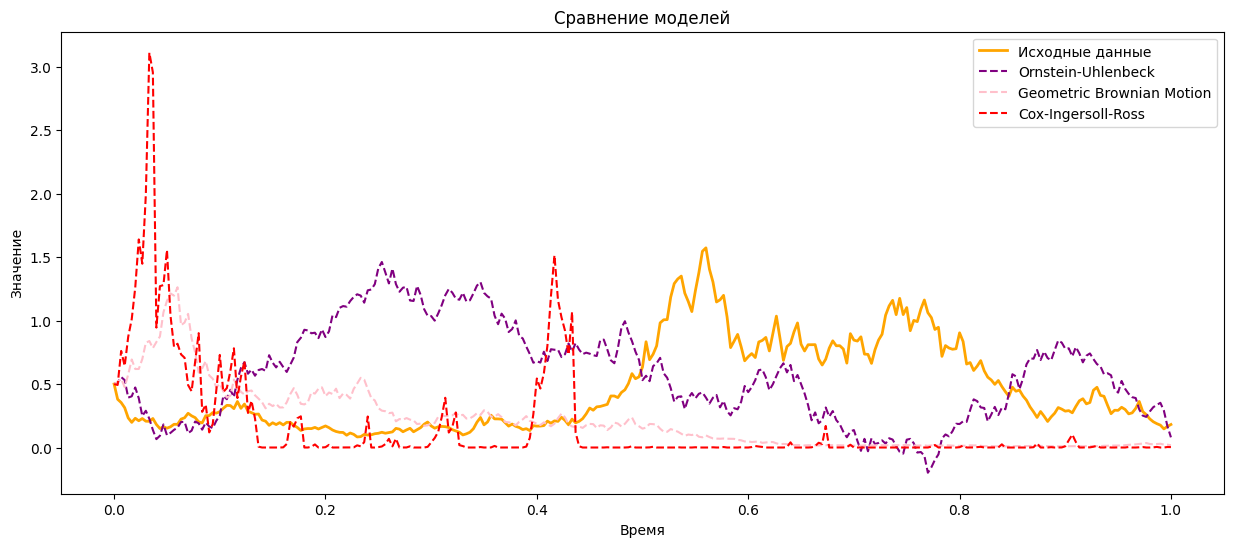

In [205]:
file = pd.read_csv('10.csv')

model = Models(file)


# Assuming model is an instance of FinancialModels
cir_sim = model.simulate_cir(model.theta_cir, model.mu_cir, model.sigma_cir, model.values[0], model.dt, len(model.values))
ou_sim = model.simulate_ou(model.theta_ou, model.mu_ou, model.sigma_ou, model.values[0], model.dt, len(model.values))
gbm_sim = model.simulate_gbm(model.mu_gbm, model.sigma_gbm, model.values[0], model.dt, len(model.values))

# Compute MSE values for the models
mse_ou = model.compute_mse(model.values, ou_sim)
mse_gbm = model.compute_mse(model.values, gbm_sim)
mse_cir = model.compute_mse(model.values, cir_sim)

# Print MSE values
print(f"MSE Ornstein-Uhlenbeck: {mse_ou}")
print(f"MSE Geometric Brownian Motion: {mse_gbm}")
print(f"MSE Cox-Ingersoll-Ross: {mse_cir}")

# Plot the comparison using matplotlib
plot_comparison(model.time, model.values, cir_sim, ou_sim, gbm_sim)


In [ ]:
# your code